# Purpose: Create a function to align images using the SWarp Library and Verify it's accuracy

In [1]:
import glob
import os
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
import subprocess
import numpy as np

In [2]:
def convert_sci_to_ref(file):
    info = file.split("_")[2:-1]
    return "/media/rd1/ztf_neos/pipeline/reference/ztf_" + "_".join(info[1:4] + info[5:6]) + "_refimg.fits"

def swarp_align(sci_file, ref_file):
    header = fits.getheader(ref_file)

    with open("/home/fwang/Pipeline/coadd.head", "w") as f:
        f.write(repr(header) + "\nEND     ")

    subprocess.run(["swarp", sci_file, "-c", "/home/fwang/Pipeline/swarp.conf"],
                   cwd="/home/fwang/Pipeline", stderr=subprocess.DEVNULL)

    return [fits.getdata("/home/fwang/Pipeline/coadd.fits"),
            fits.getdata(ref_file)]

In [3]:
# align the reference file to the science, returns science and reference
def swarp_align(sci_file, ref_file):
    ref, header = fits.getdata(ref_file, header=True)

    filename_sci = sci_file.split("/")[-1]
    directory = "/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci[:-len(".fits")]
    
    os.makedirs(directory, exist_ok=True)
    with open(directory + "/coadd.head", "w") as f:
        f.write(repr(header) + "\nEND     ")

    subprocess.run(["swarp", sci_file, "-c", "/home/fwang/Pipeline/swarp.conf", "-VERBOSE_TYPE", "QUIET"],
                     cwd=directory, stderr=subprocess.DEVNULL)

    return [fits.getdata(directory + "/coadd.fits"), ref]

In [4]:
filenames = glob.glob("/media/rd1/ztf_neos/pipeline/science/*.fits")
filename_pairs = [(file, convert_sci_to_ref(file)) for file in filenames]
filename_pairs = [pair for pair in filename_pairs if os.path.isfile(pair[1])]

In [5]:
sci_file, ref_file = filename_pairs[0]

In [22]:
print(ref_file)

/media/rd1/ztf_neos/pipeline/reference/ztf_000599_zr_c02_q3_refimg.fits


In [6]:
sci = fits.getdata(sci_file)
ref = fits.getdata(ref_file)

In [7]:
%%time
sci_align, ref_align = swarp_align(sci_file, ref_file)

CPU times: user 8.47 ms, sys: 3.38 ms, total: 11.8 ms
Wall time: 7.92 s


In [8]:
sci_align[~np.isfinite(sci_align)] = 0

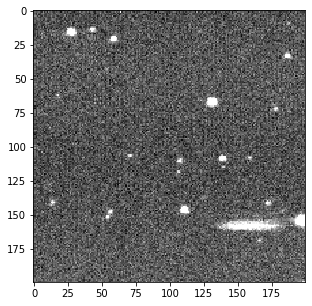

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(normalize(sci[2600:2800, -500:-700:-1]), cmap="gray")

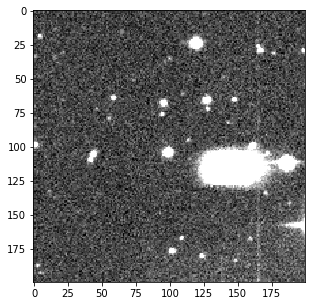

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(normalize(ref[2600:2800, 550:750]), cmap="gray")

In [10]:
size = 80
def normalize(arr, samples=size * size // 4):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)
    return (arr - 0.5) * 2